# Configuring libraries & utilities

In [1]:
# Upgrade scikit-learn
!pip install --upgrade scikit-learn -q

# If you are using Google Colab, after upgrading scikit-learn, you may need to restart the runtime to run the following cells.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 35.3 MB/s eta 0:00:00


In [2]:
# Standard Library Imports
import os
import json
import math

# Google Drive Integration
from google.colab import drive

# Data Manipulation and Preprocessing
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Data Preprocessing and Transformation
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    LabelEncoder, OneHotEncoder, StandardScaler, PowerTransformer, QuantileTransformer,
    FunctionTransformer
)

# Machine Learning Models
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier,
    VotingClassifier
)

# Model Evaluation and Hyperparameter Tuning
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Saving
import joblib

# Custom Modules for additional functionalities
try:
    import flash as fz
except ImportError:
    # Install the custom module if not present
    !pip install git+https://github.com/Althaf9900/flash.git -q
    import flash as fz

  Preparing metadata (setup.py) ... done


In [3]:
# Mount Google Drive if it's not already mounted
mount_point = "/content/drive"

if not os.path.ismount(mount_point):
    print("Mounting Google Drive...")
    drive.mount(mount_point)
else:
    print("Google Drive is already mounted.")

%cd /content/drive/MyDrive/Projects/loan-sanction-prediction

Mounting Google Drive...
Mounted at /content/drive
/content/drive/MyDrive/Projects/loan-sanction-prediction



# Initial data assessment & preparation


In [4]:
# Loading the train dataset
df_copy = pd.read_csv('loan_sanction_train.csv')
df = df_copy

In [5]:
# Understanding structure of the dataset
df.sample(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
512,LP002643,Male,Yes,2,Graduate,No,3283,2035.0,148.0,360.0,1.0,Urban,Y
398,LP002284,Male,No,0,Not Graduate,No,3902,1666.0,109.0,360.0,1.0,Rural,Y
548,LP002776,Female,No,0,Graduate,No,5000,0.0,103.0,360.0,0.0,Semiurban,N
536,LP002734,Male,Yes,0,Graduate,No,6133,3906.0,324.0,360.0,1.0,Urban,Y


In [6]:
# Checking whether Loan_ID contains duplicate IDs
df['Loan_ID'].duplicated().sum()

0

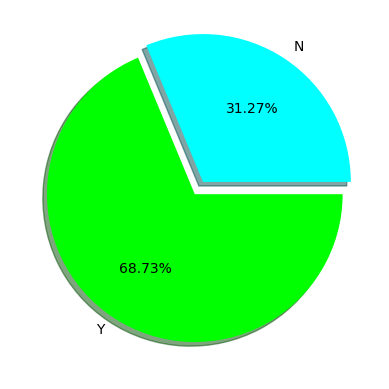

In [7]:
# Checking whether the dataset is imbalanced or not
plt.pie(df['Loan_Status'].value_counts(), labels = df['Loan_Status'].unique(), autopct='%0.2f%%',
        shadow=True, explode=(0, 0.1), counterclock=False, colors=['lime', 'cyan'])
plt.show()

In [8]:
# Columns of the dataset
print(df.columns)

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')


In [9]:
# Getting some information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [10]:
# Dropping useless features
df.drop('Loan_ID', axis=1, inplace=True)

In [11]:
# Extracting numerical features & categorical features from the dataset using a custom made module
num_cols = fz.get_num_col(df)
cat_cols = fz.get_cat_col(df, ignore_cols=['Loan_Status'])

# Number of categorical features
n_cat_cols = len(cat_cols)
n_num_cols = len(num_cols)


print(num_cols)
print(cat_cols)

print(f'Number of numerical features: {n_num_cols}')
print(f'Number of categorical features: {n_cat_cols}')

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']
Number of numerical features: 3
Number of categorical features: 8



# EDA (Before data cleaning)



## Outlier analysis on numerical features


In [12]:
# Statistical measures
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0


In [ ]:
# Histogram & Box-plot

# Create subplots
fig, axs = plt.subplots(n_num_cols, 2, figsize=(12, 10))

# Plotting histograms and boxplots
for i, col in enumerate(num_cols):
    # Histogram
    sns.histplot(df[col], kde=True, ax=axs[i, 0])
    axs[i, 0].set_title(f'Histogram of {col}')

    # Boxplot
    sns.boxplot(data=df, x=col, ax=axs[i, 1])
    axs[i, 1].set_title(f'Boxplot of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Initialize a list to store features with outliers
ftrs_with_outliers = []

# Iterate through each numerical features to calculate IQR and identify outliers
for feature in df[num_cols].columns:
    # Calculate Q1, Q3, and IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Check if the feature contains any outliers
    if ((df[feature] < lower_bound) | (df[feature] > upper_bound)).any():
        ftrs_with_outliers.append(feature)

print("Features with outliers:", ftrs_with_outliers)

In [ ]:
# Applicant income
Q1 = df['ApplicantIncome'].quantile(0.25)
Q3 = df['ApplicantIncome'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df[(df['ApplicantIncome'] < lower_bound) | (df['ApplicantIncome'] > upper_bound)]['ApplicantIncome'].sort_values()

In [ ]:
# Co-applicant income
Q1 = df['CoapplicantIncome'].quantile(0.25)
Q3 = df['CoapplicantIncome'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df[(df['CoapplicantIncome'] < lower_bound) | (df['CoapplicantIncome'] > upper_bound)]['CoapplicantIncome'].sort_values()

In [ ]:
# Loan amount
Q1 = df['LoanAmount'].quantile(0.25)
Q3 = df['LoanAmount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df[(df['LoanAmount'] < lower_bound) | (df['LoanAmount'] > upper_bound)]['LoanAmount'].sort_values()

Conclusions:

- There are many outliers on the upper side of all numerical features.

- None of the numerical features have outliers on the lower side.

- Since we only have few data points, we can't afford to drop any data points.
    
- None of the numerical features follow a normal distribution.

- The outliers appear to be valid and are not due to data entry issues.

- Since the outliers are valid, apply capping methods, such as:

    - Custom threshold capping: Set a threshold value based on analysis of the boxplots.
    - Percentile-based capping: Limit outliers to a specified percentile range.
    - Median imputation: Replace extreme values with the median.

- After building the predictive model, evaluate the accuracy of all capping methods.


## Missing value analysis


In [ ]:
# Calculate the percentage of missing values in numerical features
num_miss_pct = df[num_cols].isna().mean()*100

# Filter out categorical features with no missing values
num_miss_pct = num_miss_pct[num_miss_pct > 0]

# Print the percentage of missing values for each numerical features with missing values
for index, value in num_miss_pct.items():
    print(f"{index}: {round(value, 2)}%")

# List of numerical features that have missing values
num_cols_with_na = num_miss_pct.index.to_list()

print(num_cols_with_na)

In [ ]:
# Calculate the percentage of missing values in categorical features
cat_miss_pct = df[cat_cols].isna().mean() * 100

# Filter out categorical features with no missing values
cat_miss_pct = cat_miss_pct[cat_miss_pct > 0]

# Print the percentage of missing values for each categorical feature with missing values
for feature, pct in cat_miss_pct.items():
    print(f"{feature}: {round(pct, 2)}%")

# List of categorical features that have missing values
cat_cols_with_na = cat_miss_pct.index.to_list()

print(cat_cols_with_na)

In [ ]:
# Visualizing whether the missing values are missing at random or not
plt.figure(figsize=(15, 4))
sns.heatmap(df.isna(), cbar=False, cmap="Blues", yticklabels=False)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Plotting histogram of numerical features that have missing values to decide whether to use mean or median
sns.histplot(df['LoanAmount'], kde=True)
plt.show()

Conclusions:

- Only one numerical feature (['LoanAmount']) has missing values.

- Six categorical features (['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History']) have missing values.

- Since we only have few data points, we cannot afford to drop any data points.

- The percentage of missing values is low across all features, so there is no need to drop any columns.

- It appears that the missingness of values is random.

- Missing value handling:

    - Median imputation (for numerical features that are not normally distributed):
        - Loan amount

    - Mode imputation:
        - Categorical features



# Data Cleaning


Data cleaning conclusions:

- Outlier handling:

    - Since the outliers are valid, apply capping methods, such as:

        - Custom threshold capping: Set a threshold value based on analysis of the boxplots.
        - Percentile-based capping: Limit outliers to a specified percentile range.
        - Median imputation: Replace outliers with the median.


- Missing value handling:

    - Median imputation (for numerical features that are not normally distributed):
        - Loan amount

    - Mode imputation:
        - Categorical features

- Data type adjustments:

    - Data type comapatibility:
        - Applicant income: float
        - Loan_Amount_Term: int then, str
        - Credit_History: int then, str

    - Memory usage optimization:
        - Categorical features: category
        - Numerical features: float64 -> float32

In [22]:
# Outlier handling: Custom threshold capping

# Define the cap value
cap_values = [20833, 8980, 500]

for i, feature in enumerate(ftrs_with_outliers):
    # Cap the values
    df[feature] = df[feature].clip(upper=cap_values[i])

In [23]:
# Missing value handling

# Imputing missing values in LoanAmount feature with median
median_imputer = SimpleImputer(strategy='median')
df['LoanAmount'] = median_imputer.fit_transform(df[['LoanAmount']])

# Imputing missing values in categorical features with mode
mode_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols_with_na] = mode_imputer.fit_transform(df[cat_cols_with_na])

# Test
if df.isna().sum().sum() == 0:
    print("There are no missing values left in the DataFrame.")
else:
    print("There are still missing values in the DataFrame.")

There are no missing values left in the DataFrame.


In [24]:
# Checking memory usage before dtype adjustments
print("Memory usage before adjustment:", df.memory_usage(deep=True).sum())
print()

# Data type adjustments

# Data type compatibility
df['ApplicantIncome'] = df['ApplicantIncome'].astype(float)

# Converting numerical categorical features to int
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].astype(int)
df['Credit_History'] = df['Credit_History'].astype(int)

# Converting numerical categorical features to str
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].astype(str)
df['Credit_History'] = df['Credit_History'].astype(str)

# Memory usage optimization
df[cat_cols] = df[cat_cols].astype('category')

# Print data types to confirm changes
print(df.dtypes)

# Checking memory usage after dtype adjustments
print()
print("Memory usage after adjustment:", df.memory_usage(deep=True).sum())

Memory usage before adjustment: 315494

Gender               category
Married              category
Dependents           category
Education            category
Self_Employed        category
ApplicantIncome       float64
CoapplicantIncome     float64
LoanAmount            float64
Loan_Amount_Term     category
Credit_History       category
Property_Area        category
Loan_Status            object
dtype: object

Memory usage after adjustment: 58139



# EDA (On Independent features)



## Univariate analysis



### Numerical


In [ ]:
df[num_cols].describe().T

In [ ]:
# Skewness and Kurtosis
skew_kurt_dict = {}
for col in num_cols:
    skew_kurt_dict[col] = {
        'skewness': round(float(df[col].skew()), 2),
        'kurtosis': round(float(df[col].kurtosis()), 2)
    }

print(json.dumps(skew_kurt_dict, indent=4))

In [ ]:
# Histogram & Box-plot

# Create subplots
fig, axs = plt.subplots(n_num_cols, 2, figsize=(12, 10))

# Plotting histograms and boxplots
for i, col in enumerate(num_cols):
    # Histogram
    sns.histplot(df[col], kde=True, ax=axs[i, 0])
    axs[i, 0].set_title(f'Histogram of {col}')

    # Boxplot
    sns.boxplot(data=df, x=col, ax=axs[i, 1])
    axs[i, 1].set_title(f'Boxplot of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

Conclusions:

- Applicant income and loan amount approximately follow a log-normal distribution.
- Feature transformation is needed for all numerical features.
- It appears that individuals with a co-applicant income of 0 do not have a co-applicant. Therefore, create a feature named 'Has_coapplicant'. In this feature, set individuals with a co-applicant income of 0 to 'No, and those with a non-zero co-applicant income to 'Yes.


### Categorical


In [ ]:
# Statistical measures
df[cat_cols].describe().T

In [ ]:
# Countplot

# Calculate number of rows and columns needed for subplots
n_cols = 3
n_rows = math.ceil(n_cat_cols / n_cols)

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

# Flatten axs array if it's multidimensional
axs = axs.flatten()

# Plot countplots and set titles
for i, feature in enumerate(cat_cols):
    sns.countplot(data=df, x=feature, ax=axs[i])
    axs[i].set_title(feature)
    axs[i].tick_params(axis='x', rotation=45)

# Turn off any unused subplots
for j in range(len(cat_cols), len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

Conclusions:

- Males take out more loans compared to females.
- Married individuals take out more loans compared to - unmarried individuals.
- People without dependents take out more loans compared to those with dependents.
- Graduates take out more loans compared to non-graduates.
- Non-self-employed individuals take out more loans compared to self-employed individuals.
- Most people opt for a loan term of 360 months (30 years), followed by 180 months (15 years).
- People with a credit history of 1 take out more loans compared to those with a credit history of 0.
- People living in semi-urban areas take out more loans compared to those living in rural and urban areas. Rural residents take out the fewest loans. Although these relationships aren't strong, they may represent general trends.


## Bivariate analysis



### Numerical - Numerical


In [ ]:
# Pairplot
sns.pairplot(df[num_cols], diag_kind='kde')
plt.show()

In [ ]:
# regplot with PairGrid
graph = sns.PairGrid(df)

# type of graph for diagonal
graph = graph.map_diag(sns.histplot, kde=True)

# type of graph for non-diagonal
graph = graph.map_offdiag(sns.regplot, scatter=True, line_kws={'color': 'red'})

plt.show()

In [ ]:
# Creating a custom colorbar
# Define custom colors
colors = ["#FF0000", "#FFFF00", "#00FF00"]  # Red to Yellow to Green

# Create a custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)

In [ ]:
# Function to create a mask for the upper triangle
def create_mask(df, method):
    corr = df.corr(method=method)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    np.fill_diagonal(mask, False)  # Optional: keep or remove diagonal elements
    return mask

# Function to plot heatmap
def plot_heatmap(df, method, ax, cmap, title):
    mask = create_mask(df, method)
    sns.heatmap(df.corr(method=method), mask=mask, annot=True, cmap=cmap, ax=ax, cbar=False)
    ax.set_title(title)

In [ ]:
# Heatmap

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(13, 5), gridspec_kw={'width_ratios': [1, 1, 0.05]})

# Plot Pearson and Spearman heatmaps
plot_heatmap(df[num_cols], 'pearson', axs[0], custom_cmap, 'Pearson Correlation Heatmap')
plot_heatmap(df[num_cols], 'spearman', axs[1], custom_cmap, 'Spearman Correlation Heatmap')

# Create a common colorbar for both heatmaps
cbar = fig.colorbar(axs[0].collections[0], cax=axs[2])

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

Conclusions:

- None of the features show a strong linear relationship with each other. However, there is a moderate relationship between applicant income and loan amount. This makes sense because individuals with higher incomes often need larger loan amounts.

- Both Pearson and Spearman correlation coefficients show similar patterns, but their values are slightly different. Since the heatmaps from both are similar, the exact values are less important. In this case, Spearman's correlation is more suitable because the data isn't normally distributed, doesn't have a linear relationship between features, and has outliers.


### Categorical - Categorical


In [ ]:
# Heatmap

# Create subplots
fig, axs = plt.subplots(n_cat_cols * (n_cat_cols - 1) // 2, 2, figsize=(13, 140))  # Adjust size as needed
axs = axs.reshape(-1, 2)  # Flatten the array of subplots

# Plot heatmaps
plot_index = 0
for i in range(n_cat_cols):
    for j in range(i + 1, n_cat_cols):
        # Create contingency tables
        contingency_table_1 = pd.crosstab(df[cat_cols[i]], df[cat_cols[j]], normalize='index') * 100
        contingency_table_2 = pd.crosstab(df[cat_cols[i]], df[cat_cols[j]], normalize='columns') * 100

        # Plot heatmaps
        sns.heatmap(contingency_table_1, annot=True, cmap=custom_cmap, cbar=False, fmt='0.2f',
                    xticklabels=True, yticklabels=True, ax=axs[plot_index, 0])
        sns.heatmap(contingency_table_2, annot=True, cmap=custom_cmap, cbar=False, fmt='0.2f',
                    xticklabels=True, yticklabels=True, ax=axs[plot_index, 1])

        # Set titles for each subplot
        axs[plot_index, 0].set_title(f"{cat_cols[i]} vs {cat_cols[j]} (Index Normalized)")
        axs[plot_index, 1].set_title(f"{cat_cols[i]} vs {cat_cols[j]} (Column Normalized)")

        plot_index += 1

# Adjust layout
plt.tight_layout()
plt.show()


### Numerical - Categorical


In [ ]:
# Applicant income
num_col = 'ApplicantIncome'

# Create subplots
fig, axs = plt.subplots(n_cat_cols, 2, figsize=(15, n_cat_cols * 4))

for i in range(len(cat_cols)):

    # Plot violinplot
    sns.violinplot(data=df, x=cat_cols[i], y=num_col, ax=axs[i, 0])
    axs[i, 0].set_title(f'Violinplot of {num_col} by {cat_cols[i]}')

    # Plot pointplot
    sns.pointplot(data=df, x=cat_cols[i], y=num_col, errorbar=None, color='blue', ax=axs[i, 1])
    sns.pointplot(data=df, x=cat_cols[i], y=num_col, errorbar=None, color='red', estimator='median', ax=axs[i, 1])
    axs[i, 1].set_title(f'Pointplot of {num_col} by {cat_cols[i]}')
    handles = [
        plt.Line2D([0], [0], color='blue', marker='o', markersize=8, label='Mean'),
        plt.Line2D([0], [0], color='red', marker='o', markersize=8, label='Median')
    ]
    axs[i, 1].legend(handles=handles, title='Estimation type')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Coapplicant income
num_col = 'CoapplicantIncome'

# Create subplots
fig, axs = plt.subplots(n_cat_cols, 2, figsize=(15, n_cat_cols * 4))

for i in range(len(cat_cols)):

    # Plot violinplot
    sns.violinplot(data=df, x=cat_cols[i], y=num_col, ax=axs[i, 0])
    axs[i, 0].set_title(f'Violinplot of {num_col} by {cat_cols[i]}')

    # Plot pointplot
    sns.pointplot(data=df, x=cat_cols[i], y=num_col, errorbar=None, color='blue', ax=axs[i, 1])
    sns.pointplot(data=df, x=cat_cols[i], y=num_col, errorbar=None, color='red', estimator='median', ax=axs[i, 1])
    axs[i, 1].set_title(f'Pointplot of {num_col} by {cat_cols[i]}')
    handles = [
        plt.Line2D([0], [0], color='blue', marker='o', markersize=8, label='Mean'),
        plt.Line2D([0], [0], color='red', marker='o', markersize=8, label='Median')
    ]
    axs[i, 1].legend(handles=handles, title='Estimation type')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Loan amount
num_col = 'LoanAmount'

# Create subplots
fig, axs = plt.subplots(n_cat_cols, 2, figsize=(15, n_cat_cols * 4))

for i in range(len(cat_cols)):

    # Plot violinplot
    sns.violinplot(data=df, x=cat_cols[i], y=num_col, ax=axs[i, 0])
    axs[i, 0].set_title(f'Violinplot of {num_col} by {cat_cols[i]}')

    # Plot pointplot
    sns.pointplot(data=df, x=cat_cols[i], y=num_col, errorbar=None, color='blue', ax=axs[i, 1])
    sns.pointplot(data=df, x=cat_cols[i], y=num_col, errorbar=None, color='red', estimator='median', ax=axs[i, 1])
    axs[i, 1].set_title(f'Pointplot of {num_col} by {cat_cols[i]}')
    handles = [
        plt.Line2D([0], [0], color='blue', marker='o', markersize=8, label='Mean'),
        plt.Line2D([0], [0], color='red', marker='o', markersize=8, label='Median')
    ]
    axs[i, 1].legend(handles=handles, title='Estimation type')

# Adjust layout
plt.tight_layout()
plt.show()


# Feature construction


- It appears that individuals with a co-applicant income of 0 do not have a co-applicant. Therefore, create a feature named 'Has_coapplicant'. In this feature, set individuals with a co-applicant income of 0 to 'No', and those with a non-zero co-applicant income to 'Yes'.

In [25]:
df['Has_coapplicant'] = np.where(df['CoapplicantIncome'] == 0, 'No', 'Yes')
df['Has_coapplicant']

,Has_coapplicant
0,No
1,Yes
2,No
3,Yes
4,No
...,...
609,No
610,No
611,Yes
612,No


In [26]:
# Appending newly constructed features to feature lists based on their type
cat_cols.append('Has_coapplicant')


# EDA (On newly constructed features)



## Univariate analysis


In [ ]:
df['Has_coapplicant'].describe().T

In [ ]:
sns.countplot(x = df['Has_coapplicant'])
plt.show()


## Bivariate analysis



#### Categorical - Categorical

In [ ]:
# Heatmap

# Create subplots
fig, axs = plt.subplots(n_cat_cols, 2, figsize=(13, 40))  # Adjust size as needed
axs = axs.reshape(-1, 2)  # Flatten the array of subplots

# Plot heatmaps
for i in range(n_cat_cols):
    # Create contingency tables
    contingency_table_1 = pd.crosstab(df[cat_cols[i]], df['Has_coapplicant'], normalize='index') * 100
    contingency_table_2 = pd.crosstab(df[cat_cols[i]], df['Has_coapplicant'], normalize='columns') * 100

    # Plot heatmaps
    sns.heatmap(contingency_table_1, annot=True, cmap=custom_cmap, cbar=False, fmt='0.2f',
                xticklabels=True, yticklabels=True, ax=axs[i, 0])
    sns.heatmap(contingency_table_2, annot=True, cmap=custom_cmap, cbar=False, fmt='0.2f',
                xticklabels=True, yticklabels=True, ax=axs[i, 1])

    # Set titles for each subplot
    axs[i, 0].set_title(f"{cat_cols[i]} vs Has_coapplicant (Index Normalized)")
    axs[i, 1].set_title(f"{cat_cols[i]} vs Has_coapplicant (Column Normalized)")

# Adjust layout
plt.tight_layout()
plt.show()


#### Numerical - Categorical


In [ ]:
# Violinplot & Pointplot

# Create subplots
fig, axs = plt.subplots(n_num_cols, 2, figsize=(12, 9))

for i in range(n_num_cols):

    # Plot violinplot
    sns.violinplot(data=df, x='Has_coapplicant', y=num_cols[i], ax=axs[i, 0])
    axs[i, 0].set_title(f'Violinplot of {num_cols[i]} by Has_coapplicant')

    # Plot pointplot
    sns.pointplot(data=df, x='Has_coapplicant', y=num_cols[i], errorbar=None, color='blue', ax=axs[i, 1])
    sns.pointplot(data=df, x='Has_coapplicant', y=num_cols[i], errorbar=None, color='red', estimator='median', ax=axs[i, 1])
    axs[i, 1].set_title(f'Pointplot of {num_cols[i]} by Has_coapplicant')
    handles = [
        plt.Line2D([0], [0], color='blue', marker='o', markersize=8, label='Mean'),
        plt.Line2D([0], [0], color='red', marker='o', markersize=8, label='Median')
    ]
    axs[i, 1].legend(handles=handles, title='Estimation type')

# Adjust layout
plt.tight_layout()
plt.show()


# EDA (Between independent features and target feature)


## Categorical - Categorical


In [ ]:
# Heatmap

# Create subplots
fig, axs = plt.subplots(n_cat_cols, 2, figsize=(13, 40))  # Adjust size as needed
axs = axs.reshape(-1, 2)  # Flatten the array of subplots

# Plot heatmaps
for i in range(n_cat_cols):
    # Create contingency tables
    contingency_table_1 = pd.crosstab(df[cat_cols[i]], df['Loan_Status'], normalize='index') * 100
    contingency_table_2 = pd.crosstab(df[cat_cols[i]], df['Loan_Status'], normalize='columns') * 100

    # Plot heatmaps
    sns.heatmap(contingency_table_1, annot=True, cmap=custom_cmap, cbar=False, fmt='0.2f',
                xticklabels=True, yticklabels=True, ax=axs[i, 0])
    sns.heatmap(contingency_table_2, annot=True, cmap=custom_cmap, cbar=False, fmt='0.2f',
                xticklabels=True, yticklabels=True, ax=axs[i, 1])

    # Set titles for each subplot
    axs[i, 0].set_title(f"{cat_cols[i]} vs Loan_Status (Index Normalized)")
    axs[i, 1].set_title(f"{cat_cols[i]} vs Loan_Status (Column Normalized)")

# Adjust layout
plt.tight_layout()
plt.show()


## Numerical - Categorical


In [ ]:
# Violinplot & Pointplot

# Create subplots
fig, axs = plt.subplots(n_num_cols, 2, figsize=(12, 9))

for i in range(n_num_cols):

    # Plot violinplot
    sns.violinplot(data=df, x='Loan_Status', y=num_cols[i], ax=axs[i, 0])
    axs[i, 0].set_title(f'Violinplot of {num_cols[i]} by Loan_Status')

    # Plot pointplot
    sns.pointplot(data=df, x='Loan_Status', y=num_cols[i], errorbar=None, color='blue', ax=axs[i, 1])
    sns.pointplot(data=df, x='Loan_Status', y=num_cols[i], errorbar=None, color='red', estimator='median', ax=axs[i, 1])
    axs[i, 1].set_title(f'Pointplot of {num_cols[i]} by Loan_Status')
    handles = [
        plt.Line2D([0], [0], color='blue', marker='o', markersize=8, label='Mean'),
        plt.Line2D([0], [0], color='red', marker='o', markersize=8, label='Median')
    ]
    axs[i, 1].legend(handles=handles, title='Estimation type')

# Adjust layout
plt.tight_layout()
plt.show()



# Feature transformation


In [27]:
# Epsilon to avoid log(0) and sqrt(0)
epsilon = 1e-10

# Initialize transformers
transformers = {
    'Log': FunctionTransformer(func=lambda X: np.log(X + epsilon), validate=False),
    'Square Root': FunctionTransformer(func=lambda X: np.sqrt(X + epsilon),
                                       validate=False),
    'Square': FunctionTransformer(func=np.square, validate=False),
    'Reciprocal': FunctionTransformer(func=lambda X: np.reciprocal(X + epsilon),
                                      validate=False),
    'Yeo-Johnson': PowerTransformer(standardize=False),
    'Quantile': QuantileTransformer(n_quantiles=df.shape[0], output_distribution='normal')
}

# Apply transformations
transformed_data = {}
for name, transformer in transformers.items():
    transformed_data[name] = pd.DataFrame(transformer.fit_transform(df[num_cols]),
                                          columns=num_cols)

In [ ]:
# Histogram

# Create subplots
fig, axs = plt.subplots(n_num_cols, len(transformers) + 1, figsize=(26, 9))

# Plot histograms
for i, col in enumerate(num_cols):
    # Original
    sns.histplot(df[col], kde=True, ax=axs[i, 0])
    axs[i, 0].set_title(f'Original {col}')

    for j, (name, transformed_df) in enumerate(transformed_data.items()):
        sns.histplot(transformed_df[col], kde=True, ax=axs[i, j + 1])
        axs[i, j + 1].set_title(f'{name} {col}')

# Turn off y axis labels for all subplots
axs = axs.flatten()
for ax in axs:
    ax.set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# QQ plot

# Create subplots
fig, axs = plt.subplots(n_num_cols, len(transformers) + 1, figsize=(26, 9))

# Plot Q-Q plots
for i, col in enumerate(num_cols):
    # Original
    stats.probplot(df[col], dist="norm", plot=axs[i, 0])
    axs[i, 0].set_title(f'Original {col}')
    axs[i, 0].get_lines()[1].set_color('red')  # Make the reference line red

    for j, (name, transformed_df) in enumerate(transformed_data.items()):
        stats.probplot(transformed_df[col], dist="norm", plot=axs[i, j + 1])
        axs[i, j + 1].set_title(f'{name} {col}')
        axs[i, j + 1].get_lines()[1].set_color('red')  # Make the reference line red

# Turn off x and y axis labels for all subplots
axs = axs.flatten()
for ax in axs:
    ax.set_xlabel('')
    ax.set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()

Conclusions:

- ApplicantIncome & LoanAmount: Quantile Transform
- CoapplicantIncome: Reciprocal Transform

In [28]:
df['ApplicantIncome'] = transformed_data['Quantile']['ApplicantIncome']
df['CoapplicantIncome'] = transformed_data['Reciprocal']['CoapplicantIncome']
df['LoanAmount'] = transformed_data['Quantile']['LoanAmount']


# Building predictive model


## Preparing the data


In [105]:
# Splitting the data into features and target
X_train = df.drop('Loan_Status', axis=1)
X_train = X_train[num_cols + cat_cols] # To place numerical columns first
y_train = df['Loan_Status']

In [46]:
# Label encode the target feature

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the target feature
y_train = le.fit_transform(y_train)

In [111]:
# Getting indices of numerical and categorical features of the X_train dataframe
indices_num_cols = X_train.columns.get_indexer(num_cols)
indices_cat_cols = X_train.columns.get_indexer(cat_cols)

In [112]:
# Column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), indices_num_cols), # Scaling numerical columns
        ('encoder', OneHotEncoder(drop='first', sparse_output=False), indices_cat_cols) # OneHotEncoding categorical columns
    ],
    remainder='passthrough'  # Keep the columns not listed in num_cols or cat_cols as is
)

In [113]:
# Pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor)
])

In [114]:
# Preprocessing and Transforming training data using pipeline
X_train_transformed = pipe.fit_transform(X_train)


### Handling imbalanced dataset


In [43]:
# Oversampling the dataset using SMOTE
smote = SMOTE(random_state=42)  # Initialize SMOTE with optional random_state for reproducibility
X_train_transformed, y_train = smote.fit_resample(X_train_transformed, y_train)

In [44]:
# Test
unique_values, counts = np.unique(y_train, return_counts=True)

# Print the counts of each class
for value, count in zip(unique_values, counts):
    print(f"Class {value}: {count}")

Class 0: 422
Class 1: 422



## Model selection (Before hyperparameter tuning)


In [ ]:
# Define models
models = {
    'Logistic Regression': LogisticRegression,
    'Random Forest': RandomForestClassifier,
    'Gradient Boosting': GradientBoostingClassifier,
    'Support Vector Machine': SVC,
    'KNN': KNeighborsClassifier,
    'Decision Trees': DecisionTreeClassifier,
    'Xgboost': XGBClassifier,
    'Extra Trees': ExtraTreesClassifier
}
# Define metric functions
metrics = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score
}

In [ ]:
def eval_models_across_metrics(models, metrics, X_train, y_train, cv=5, sort=False, model_params=None):

    models_across_metrics = {metric: {} for metric in metrics}

    for metric in metrics:
        for model_name, model in models.items():

            if isinstance(model_params, dict):
                cv_scores = cross_val_score(model(**model_params[model_name]), X_train,
                                            y_train, cv=cv, scoring=metric)
            else:
                cv_scores = cross_val_score(model(), X_train,
                                            y_train, cv=cv, scoring=metric)

            cv_scores_mean = cv_scores.mean()

            models_across_metrics[metric][model_name] = round(cv_scores_mean, 3)

    if sort:
        for metric, model_scores in models_across_metrics.items():
            models_across_metrics[metric] = dict(
                sorted(model_scores.items(), key=lambda item: item[1], reverse=True)
                )

    return models_across_metrics

In [ ]:
# Comparing models across metrics
models_across_metrics = eval_models_across_metrics(models, metrics.keys(), X_train_transformed,
                                                   y_train, sort=True)
print(json.dumps(models_across_metrics, indent=4))

Conclusions:

After evaluating the metrics, I have decided to focus on the top 3 models: Random Forest Classifier, Extra Trees Classifier, Xgboost Classifier. These models have demonstrated strong performance across the different metrics, making them the best candidates for further fine-tuning and optimization.


## Hyperparameter tuning


In [69]:
# Define top models for further hyperparameter tuning
models = {
    'Random Forest': RandomForestClassifier,
    'Xgboost': XGBClassifier,
    'Extra Trees': ExtraTreesClassifier
}

In [ ]:
# Define parameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'Xgboost': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2]
    },
    'Extra Trees': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
}

In [ ]:
def perform_grid_search(models, param_grids, X_train, y_train):
    best_params = {}
    for model_name, model in models.items():
        print(f"Processing {model_name}...")
        param_grid = param_grids[model_name]
        grid_search = GridSearchCV(estimator=model(), param_grid=param_grid,
                                   scoring='accuracy', cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_params[model_name] = {
            'Best Parameters': grid_search.best_params_,
            'Average accuracy score on the best parameters': round(grid_search.best_score_, 3)
        }
    return best_params

In [ ]:
# Finding best hyperparameters on top models using GridSearchCV
best_params = perform_grid_search(models, param_grids, X_train_transformed, y_train)

# Print best results from grid search
print(json.dumps(best_params, indent=4))

In [70]:
best_params_manual = {
    'Random Forest': {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1},
    'Xgboost': {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 0},
    'Extra Trees': {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True}
}

In [ ]:
# Comparing top models across metrics after hyperparameter tuning
models_across_metrics = eval_models_across_metrics(models, metrics.keys(), X_train_transformed,
                                                   y_train, sort=True, model_params=best_params_manual)
print(json.dumps(models_across_metrics, indent=4))

In [71]:
estimators = []
for model_name, model in models.items():
    estimators.append((model_name, model(**best_params_manual[model_name])))

In [72]:
# Create a voting classifier (hard voting)
voting_clf_hard = VotingClassifier(estimators=estimators, voting='hard')

# Create a voting classifier (soft voting)
voting_clf_soft = VotingClassifier(estimators=estimators, voting='soft')

# Apply cross-validation
cv_scores_h = cross_val_score(voting_clf_hard, X_train_transformed, y_train, cv=5,
                              scoring='accuracy')
cv_scores_s = cross_val_score(voting_clf_soft, X_train_transformed, y_train, cv=5,
                              scoring='accuracy')

# Print cross-validation results
print(f'Mean Cross-Validation Accuracy on Hard Margin: {cv_scores_h.mean():.3f}')
print(f'Mean Cross-Validation Accuracy on Soft Margin: {cv_scores_s.mean():.3f}')

Mean Cross-Validation Accuracy on Hard Margin: 0.783
Mean Cross-Validation Accuracy on Soft Margin: 0.788


In [77]:
# Fit the best model
voting_clf_soft.fit(X_train_transformed, y_train)

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(max_depth=20)),
                             ('Xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            grow_policy=None,
                                            importa...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('Extra Trees',
                              ExtraTreesClassifier(bootstrap=True, max_depth=20,
                                                   min_samples_leaf=2,
                                                   min_samples_split=5))],
                 voting='soft')

## Saving

In [78]:
# Save the Machine Learning model
joblib.dump(voting_clf_soft, 'model.joblib')

['model.joblib']

In [115]:
# Save the preprocessing steps
joblib.dump(pipe, 'preprocessor.joblib')

['preprocessor.joblib']